<a href="https://colab.research.google.com/github/okada-t-rafael/pytorch_study/blob/master/06_pytorch_transfer_learning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercises

In [1]:
# Download repository
!git clone https://github.com/okada-t-rafael/pytorch_study.git
!mv pytorch_study/going_modular .
!rm -rf pytorch_study

Cloning into 'pytorch_study'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 63 (delta 21), reused 9 (delta 1), pack-reused 0
Receiving objects: 100% (63/63), 5.36 MiB | 10.90 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [2]:
# Install requirements
!pip install -q torchinfo
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [37]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
import random
import requests
import torch
import torchvision

from PIL import Image
from going_modular import data_setup, engine, get_data, plot_results
from mlxtend.plotting import plot_confusion_matrix
from pathlib import Path
from timeit import default_timer as timer
from torch import nn
from torchinfo import summary
from torchmetrics import ConfusionMatrix
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

## Train Model

In [4]:
# Setting logging level.
logging.getLogger().setLevel(logging.INFO)

In [5]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

### Get data

In [6]:
# Some definitions
DATASET_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip"
WORK_FOLDER = "pizza_steak_sushi"

# Donwload and unzip images.
image_path, _ = get_data.download_zip_dataset(DATASET_URL, WORK_FOLDER)

INFO:root:Creating directory: 'data/pizza_steak_sushi'
INFO:root:Downloading: 'pizza_steak_sushi_20_percent.zip'
INFO:root:Unzipping: 'pizza_steak_sushi_20_percent.zip'


### Create Datasets and DataLoaders

In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# Get the transforms used to create our pretrianed weights
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
# Create Dataloaders using automatic transforms
dataloaders, class_name_list, _ = data_setup.create_dataloaders(
    image_path=image_path,
    train_transform=auto_transform,
    test_transform=auto_transform,
    batch_size=32)

INFO:root:Creating Datasets.
INFO:root:Turning train and test datasets into dataloaders.


### Getting a pretrained model

In [10]:
# NEW method of creating a pretrained model (torchvision v0.13+)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    param.requires_grad = False

# Update the classifier head of our model to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(
        in_features=1280,
        out_features=len(class_name_list))
    ).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


In [11]:
summary(
    model=model,
    input_size=(1, 3, 224, 224),  # example of [batch_size, color_channels, height, width]
    col_names=["input_size", "trainable"],
    row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]          Partial
├─Sequential (features)                                      [1, 3, 224, 224]          False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]          False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]          False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]         False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]         --
│    └─Sequential (1)                                        [1, 32, 112, 112]         False
│    │    └─MBConv (0)                                       [1, 32, 112, 112]         False
│    └─Sequential (2)                                        [1, 16, 112, 112]         False
│    │    └─MBConv (0)                                       [1, 16

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0005)

In [13]:
# Setup training and save the results
start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=dataloaders[0],
    test_dataloader=dataloaders[1],
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device)

end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

 - Epoch: 0 | Train_loss: 1.0449, Train_acc: 0.438% | Test_loss: 0.8818, Test_acc: 0.781%
 - Epoch: 1 | Train_loss: 0.8640, Train_acc: 0.744% | Test_loss: 0.7654, Test_acc: 0.806%
 - Epoch: 2 | Train_loss: 0.7417, Train_acc: 0.817% | Test_loss: 0.6786, Test_acc: 0.809%
 - Epoch: 3 | Train_loss: 0.6582, Train_acc: 0.854% | Test_loss: 0.6093, Test_acc: 0.843%
 - Epoch: 4 | Train_loss: 0.6419, Train_acc: 0.823% | Test_loss: 0.5518, Test_acc: 0.852%
 - Epoch: 5 | Train_loss: 0.5453, Train_acc: 0.850% | Test_loss: 0.5158, Test_acc: 0.858%
 - Epoch: 6 | Train_loss: 0.5162, Train_acc: 0.863% | Test_loss: 0.4769, Test_acc: 0.879%
 - Epoch: 7 | Train_loss: 0.4903, Train_acc: 0.890% | Test_loss: 0.4694, Test_acc: 0.861%
 - Epoch: 8 | Train_loss: 0.4485, Train_acc: 0.900% | Test_loss: 0.4373, Test_acc: 0.888%
 - Epoch: 9 | Train_loss: 0.4901, Train_acc: 0.860% | Test_loss: 0.4251, Test_acc: 0.889%
Total training time: 50.082 seconds


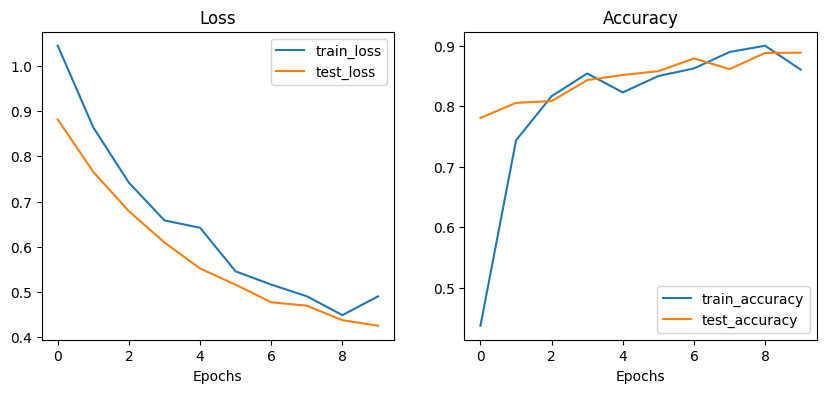

In [14]:
plot_results.plot_loss_curves(results)

## Exercise 1

Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out 03. PyTorch Computer Vision section 10 for ideas.

In [15]:
y_probs = []
model.eval()
with torch.inference_mode():
    for X_batch, y_batch in tqdm(dataloaders[1], desc="Making predictions"):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch_logit = model(X_batch)
        y_batch_prob = torch.softmax(y_batch_logit, dim=1)
        y_probs.append(y_batch_prob.cpu())
y_probs = torch.cat(y_probs)

Making predictions:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
y_preds = y_probs.argmax(dim=1)
y_preds[:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
y = torch.cat([y for X, y in dataloaders[1]])

In [18]:
conf_mat = ConfusionMatrix(
    num_classes=len(class_name_list),
    task="multiclass")
conf_mat_tensor = conf_mat(
    preds=y_preds,
    target=y)

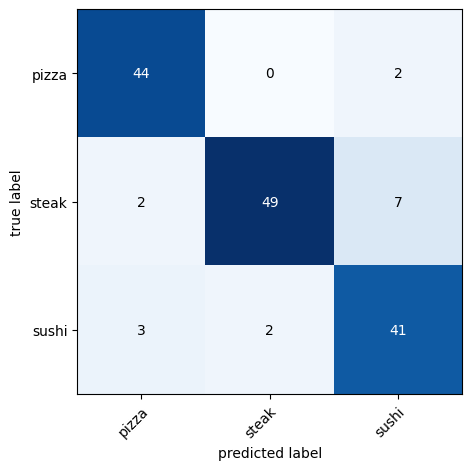

In [19]:
fix, ax = plot_confusion_matrix(
    conf_mat=conf_mat_tensor.numpy(),
    class_names=class_name_list,
    figsize=(7, 5))

## Exercise 2

Get the "most wrong" of the predictions on the teste dataset and plot the 5 "most wrong" images. You can do this by:

* Predicting across all the test dataset, storing the labels and predicted probabilities.

* Sort the predictions by wrong predictions and them descending predicted probabilities, this will give you the wrong predictions with the highest prediction probabilities, in other words, the "most wrong".

* Plot the top 5 "most wrong" images, why do you think the model got these wrong?


In [26]:
# Get all test data paths
test_data_paths = list(Path(image_path / "test").glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

In [32]:
test_pred_list = []

for path in tqdm(test_data_paths):
    pred_dict = {}
    pred_dict["image_path"] = path
    pred_dict["class_name"] = path.parent.stem

    img = Image.open(path)
    transformed_image = auto_transform(img).unsqueeze(dim=0)
    model.eval()
    with torch.inference_mode():
        pred_logit = model(transformed_image.to(device))
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_name_list[pred_label.cpu()]

        pred_dict["pred_prob"] = pred_prob.unsqueeze(dim=0).max().cpu().item()
        pred_dict["pred_class"] = pred_class

    pred_dict["correct"] = pred_dict["class_name"] == pred_class
    test_pred_list.append(pred_dict)

  0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
test_pred_df = pd.DataFrame(test_pred_list)
test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,correct
0,data/pizza_steak_sushi/test/steak/3757027.jpg,steak,0.458097,sushi,False
1,data/pizza_steak_sushi/test/steak/1655387.jpg,steak,0.573412,sushi,False
2,data/pizza_steak_sushi/test/steak/1848936.jpg,steak,0.622146,steak,True
3,data/pizza_steak_sushi/test/steak/3479599.jpg,steak,0.487662,sushi,False
4,data/pizza_steak_sushi/test/steak/3063435.jpg,steak,0.759621,steak,True


In [35]:
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head(5)
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
8,data/pizza_steak_sushi/test/steak/39461.jpg,steak,0.641509,pizza,False
144,data/pizza_steak_sushi/test/sushi/124279.jpg,sushi,0.638014,pizza,False
42,data/pizza_steak_sushi/test/steak/1335842.jpg,steak,0.612249,pizza,False
10,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.585003,sushi,False
1,data/pizza_steak_sushi/test/steak/1655387.jpg,steak,0.573412,sushi,False


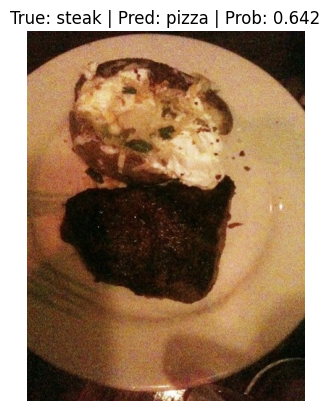

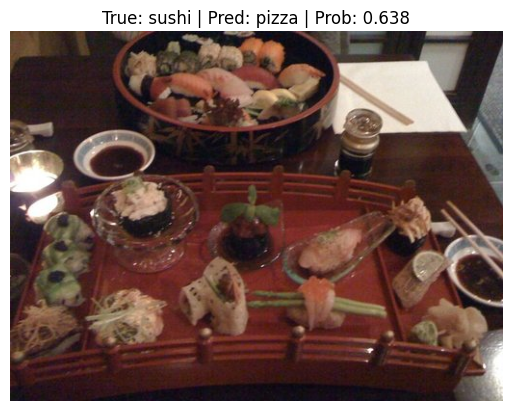

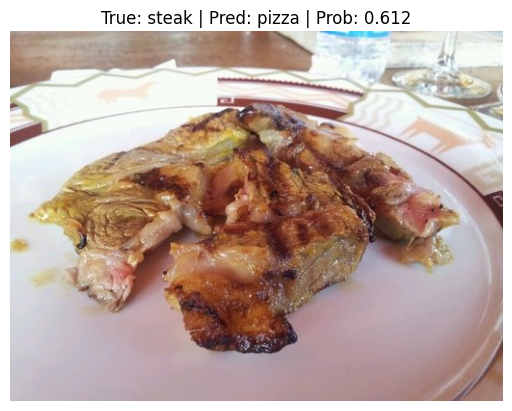

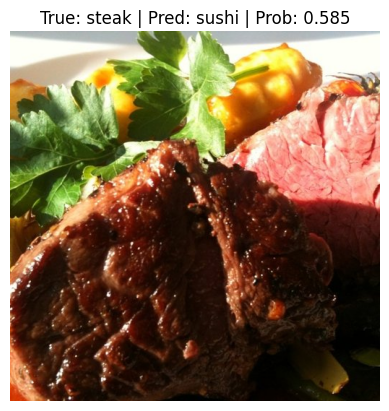

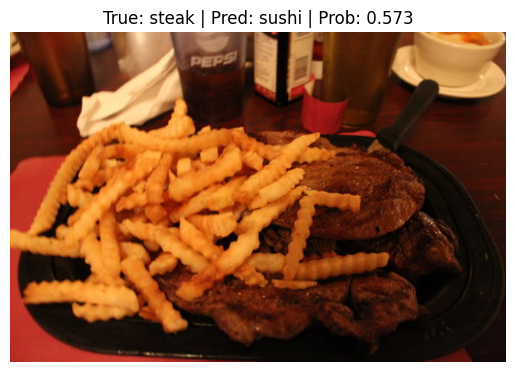

In [46]:
for _11, row in top_5_most_wrong.iterrows():
    image_path = row[0]
    true_label = row[1]
    pred_prob = row[2]
    pred_class = row[3]

    img = torchvision.io.read_image(str(image_path))
    plt.figure()
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
    plt.axis(False);